# Read BicikeLJ data

In [1]:
# Matplotlib inline
%matplotlib inline
# Imports
from urllib.request import urlopen
import json
#import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import datetime

Branje podatkov po protokolih, opisanih v: https://developer.jcdecaux.com/#/opendata/vls?page=getstarted

Zanimiva je diplomska naloga: http://geo.ff.uni-lj.si/pisnadela/pdfs/zaksem_201409_ziga_jamnik.pdf

In [2]:
# Parameters
# Station static infos
station_info_url = "https://developer.jcdecaux.com/rest/vls/stations/Ljubljana.json"
# Bycicle, station dynamic infos
station_data_url = "https://api.jcdecaux.com/vls/v1/stations?contract=Ljubljana&apiKey=0a494317d60d3d556d0755600b078ea6b26af90f"
# Station info dataframe
station_info_fn = "bicikelj_station_info.csv"
station_data_fn = "bicikelj_station_data.csv"

## Station info

In [3]:
response = urlopen(station_info_url)
if response.code == 200:
    data = response.read().decode('utf-8')
else:
    print("Wrong response from ", station_info_url)

In [4]:
response.code

200

In [5]:
station_info_json = json.loads(data)

In [6]:
station_info = pd.DataFrame(station_info_json).sort_values(["number"]).reset_index(drop=True)

In [7]:
station_info

,address,latitude,longitude,name,number
0,Prešernov trg 6,46.051367,14.506542,PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE,1
1,Pogačarjev trg 3,46.051093,14.507186,POGAČARJEV TRG-TRŽNICA,2
2,Kongresni trg 3,46.050388,14.504623,KONGRESNI TRG-ŠUBIČEVA ULICA,3
3,Cankarjeva cesta 1,46.052431,14.503257,CANKARJEVA UL.-NAMA,4
4,Breg 20,46.046498,14.505148,BREG,5
5,Grudnovo nabrežje 3,46.045748,14.506196,GRUDNOVO NABREŽJE-KARLOVŠKA C.,6
6,Miklošičeva cesta 20,46.054168,14.507060,MIKLOŠIČEV PARK,7
7,Slovenska cesta 55c,46.056820,14.505510,BAVARSKI DVOR,8
8,Trg OF 12,46.057421,14.510265,TRG OF-KOLODVORSKA UL.,9
9,Masarykova cesta 14,46.057630,14.514264,MASARYKOVA DDC,10


In [8]:
# Save to CSV
station_info.to_csv(station_info_fn, index=True)

## Read station data

In [9]:
response = urlopen(station_data_url)
if response.code == 200:
    data = response.read().decode('utf-8')
else:
    print("Wrong response from ", station_data_url)

In [10]:
station_data_json = json.loads(data)

In [11]:
station_data = pd.DataFrame(station_data_json).sort_values(["number"]).reset_index(drop=True)

In [12]:
station_data.columns

Index(['address', 'available_bike_stands', 'available_bikes', 'banking',
       'bike_stands', 'bonus', 'contract_name', 'last_update', 'name',
       'number', 'position', 'status'],
      dtype='object')

In [13]:
station_data_real = station_data[['available_bike_stands', 'available_bikes', 'banking', 'bike_stands',
                                 'bonus', 'last_update', 'number', 'status']].copy()

In [14]:
station_data_real["last_update_time"] = pd.to_datetime(station_data_real["last_update"]*1e6)

In [15]:
station_data_real = station_data_real.set_index(["last_update_time"])

In [16]:
station_data_real.head()

,available_bike_stands,available_bikes,banking,bike_stands,bonus,last_update,number,status
last_update_time,,,,,,,,
2017-01-19 14:10:14,10,10,False,20,False,1484835014000,1,OPEN
2017-01-19 14:07:09,8,8,False,18,False,1484834829000,2,OPEN
2017-01-19 14:10:26,10,9,False,20,False,1484835026000,3,OPEN
2017-01-19 14:13:04,19,4,False,26,False,1484835184000,4,OPEN
2017-01-19 14:10:15,13,7,False,20,False,1484835015000,5,OPEN


In [17]:
try:
    station_data_full = pd.read_csv(station_data_fn, index_col="last_update_time")
    station_data_full = station_data_full.append(station_data_real).drop_duplicates()
    station_data_full.to_csv(station_data_fn, index=True)
except:
    station_data_real.to_csv(station_data_fn, index=True)

## Analyze station data

In [18]:
station_data_full = pd.read_csv(station_data_fn, index_col="last_update_time")

In [19]:
station_data_full.describe()

,available_bike_stands,available_bikes,bike_stands,last_update,number
count,195.000000,195.000000,195.000000,1.950000e+02,195.000000
mean,13.015385,6.158974,19.774359,1.484832e+12,19.400000
std,4.963243,5.216979,3.373694,1.496235e+06,10.939572
min,1.000000,0.000000,8.000000,1.484830e+12,1.000000
25%,9.000000,2.000000,18.000000,1.484831e+12,10.000000
50%,14.000000,5.000000,20.000000,1.484832e+12,20.000000
75%,17.000000,10.000000,20.500000,1.484832e+12,29.000000
max,20.000000,19.000000,26.000000,1.484835e+12,38.000000


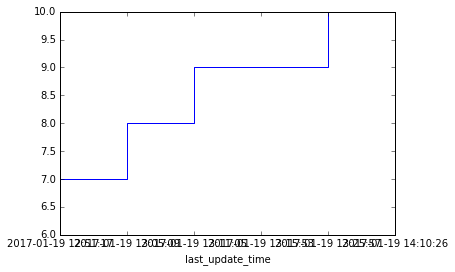

In [20]:
station_data_full[station_data_full["number"] == 3]["available_bike_stands"].plot(linestyle="steps")

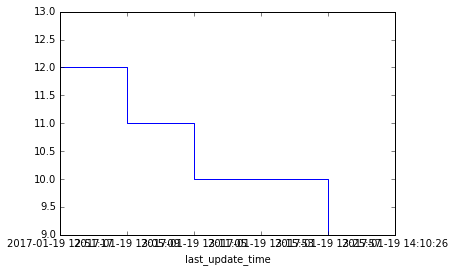

In [21]:
station_data_full[station_data_full["number"] == 3]["available_bikes"].plot(linestyle="steps")